# Análise de dados sobre exportação de vinho de mesa do Rio Grande do Sul

O objetivo desse notebook é analisar a exportação de vinho de mesa produzido no estado do Rio Grande do Sul, com foco nos últimos 15 anos (entre 2009 e 2023) e buscar responder o seguinte questionamento:

> Quais são os mercados fiéis e os possíveis mercados em expansão para exportação de vinho gaúcho?

Para isso, exploraremos as seguintes bases de dados:

* [Dados de exportação de vinho de mesa do estado do Rio Grande do Sul | Portal da Vitibrasil (Embrapa)](http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_06)
* [Dados de produção de vinhos, sucos e derivados do estado do Rio Grande do Sul | Portal da Vitibrasil (Embrapa)](http://vitibrasil.cnpuv.embrapa.br/index.php?opcao=opt_02)
* [Dados de produção, consumo, exportação e importação mundial de vinho | OIV](https://www.oiv.int/what-we-do/data-discovery-report?oiv)
* [Dados da população mundial | Banco Mundial](https://data.worldbank.org/indicator/SP.POP.TOTL)
* [Dados do crescimento anual do PIB mundial | Banco Mundial](https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG)


## Importação das bibliotecas

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

## Definição de tipografia e cores

In [4]:
# Definir paleta de cores
paleta_harmonica = {
    'azul_claro': '#8FC9B9',
    'bege_claro': '#D8D9C0',
    'rosa_claro': '#D18E8F',
    'rosa_meio': '#AB5C72',
    'rosa_escuro': '#91334F',
    'cinza_medio': '#4A4A4A',
    'cinza_muito_claro': '#E5E5E5'
}

paleta_monocromatica = {
    'bordo': '#672B3E',
    'rosa_escuro': '#8D576A',
    'rosa_medio': '#B38295',
    'rosa_claro': '#D9AEC1',
    'rosa_muito_claro': '#FFD9EC',
    'cinza_claro': '#EAEAEA',
    'cinza_escuro': '#5A5A5A'
}

Para acessar o dicionário inteiro: `list(paleta_harmonica.values())`

Para acessar uma cor específica: `paleta_monocromatica['bordo']`

In [5]:
# Configurar paleta de cores e estilo
sns.set_style('whitegrid')
sns.set_palette(list(paleta_harmonica.values()))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=list(paleta_harmonica.values()))

In [6]:
# Baixar a fonte
!wget -q -O Lato-Regular.ttf 'https://github.com/google/fonts/raw/main/ofl/lato/Lato-Regular.ttf'

# Adicionar a fonte ao Matplotlib
fm.fontManager.addfont("Lato-Regular.ttf")
fonte_lato = fm.FontProperties(fname="Lato-Regular.ttf")
nome_lato = fonte_lato.get_name()

# Definir como fonte padrão
mpl.rcParams['font.family'] = nome_lato

In [7]:
# Configurações globais
mpl.rcParams['figure.figsize'] = (12, 5)     # Tamanho padrão da figura
mpl.rcParams['axes.titlesize'] = 18          # Título dos gráficos
mpl.rcParams['axes.titlelocation'] = 'left'  # Alinhamento do título
mpl.rcParams['axes.labelsize'] = 12          # Rótulos dos eixos
mpl.rcParams['xtick.labelsize'] = 12         # Ticks eixo x
mpl.rcParams['ytick.labelsize'] = 12         # Ticks eixo y
mpl.rcParams['legend.fontsize'] = 12         # Legendas

## Contextualização

In [ ]:
# Exportar base de dados de exportação de vinho de mesa do Rio Grande do Sul
df_export = pd.read_csv('data/processed/vitibrasil-exportacao-vinho-de-mesa-1970-2024-tratado.csv')
df_export.head()

,pais,ano,quantidade,valor,regiao,iso3
0,Afeganistão,1970,0,0,Ásia,AFG
1,Afeganistão,1971,0,0,Ásia,AFG
2,Afeganistão,1972,0,0,Ásia,AFG
3,Afeganistão,1973,0,0,Ásia,AFG
4,Afeganistão,1974,0,0,Ásia,AFG


In [7]:
# Apagar o ano de 2024
df_export = df_export[df_export['ano'] != 2024]

### Cenário atual

In [8]:
# Filtrar últimos 15 anos
ano_max = df_export['ano'].max()
anos_validos = list(range(ano_max - 14, ano_max + 1))
df_export_15anos = df_export[df_export['ano'].isin(anos_validos)]
df_export_15anos.tail()

,pais,ano,quantidade,valor,regiao,iso3
7694,Índia,2019,51,273,Ásia,IND
7695,Índia,2020,7,10,Ásia,IND
7696,Índia,2021,13,86,Ásia,IND
7697,Índia,2022,247,1021,Ásia,IND
7698,Índia,2023,60,170,Ásia,IND


In [9]:
# Países que não compraram vinho do RS entre 2009 e 2023
df_export_por_pais = df_export_15anos.groupby('pais', as_index=False)['quantidade'].sum()
paises_sem_compras = list(df_export_por_pais.query('quantidade == 0')['pais'])
paises_sem_compras

['Anguilla',
 'Argélia',
 'Costa Rica',
 'Costa do Marfim',
 'Coveite (Kuweit)',
 'Gabão',
 'Ilhas Virgens',
 'Iraque',
 'Jamaica',
 'Líbano',
 'Namíbia',
 'Porto Rico',
 'Republica Eslovaca',
 'República Dominicana',
 'Senegal',
 'Sérvia',
 'Tanzânia',
 'Tunísia']

In [10]:
# Retirar países sem compra do DF
df_export_15anos = df_export_15anos[~df_export_15anos["pais"].isin(paises_sem_compras)]

In [11]:
qtde_total = df_export_15anos['quantidade'].sum()
valor_total = df_export_15anos['valor'].sum()

print(f"Nos últimos 15 anos, o Rio Grande do Sul exportou aproximadamente {qtde_total:,.0f} litros de vinho de mesa para {df_export_15anos['pais'].nunique()} países diferentes, gerando um total de US$ {valor_total:,.2f} em receita.")

Nos últimos 15 anos, o Rio Grande do Sul exportou aproximadamente 83,175,028 litros de vinho de mesa para 122 países diferentes, gerando um total de US$ 114,449,292.00 em receita.


In [12]:
# Top 5 países com maior valor e quantidade exportada nos últimos 15 anos
df_export_15anos.groupby(['pais', 'regiao'], as_index=False)[['quantidade', 'valor']].sum().sort_values(by='valor', ascending=False).head(5)

,pais,regiao,quantidade,valor
88,Paraguai,América do Sul,30803247,42862206
98,Rússia,Ásia,32822141,23151716
40,Estados Unidos,América do Norte,3349299,9309051
26,China,Ásia,2574686,4903695
95,Reino Unido,Europa,1150780,4640935


In [13]:
print(f"Em 2023, o Rio Grande do Sul exportou {df_export_15anos.query('ano == 2023')['quantidade'].sum():,.0f} litros de vinho para {df_export_15anos.query('ano == 2023 and quantidade > 0')['pais'].nunique()} países diferentes, gerando um total de US$ {df_export_15anos.query('ano == 2023')['valor'].sum():,.0f} em receita")

Em 2023, o Rio Grande do Sul exportou 5,538,888 litros de vinho para 78 países diferentes, gerando um total de US$ 8,923,076 em receita


In [14]:
# Top 5 países com maior valor e quantidade exportada em 2023
df_export_15anos.query('ano == 2023').sort_values(by='valor', ascending=False).head(5)

,pais,ano,quantidade,valor,regiao,iso3
5443,Paraguai,2023,3780378,5517263,América do Sul,PRY
3298,Haiti,2023,559645,871661,América Central e Caribe,HTI
7368,Uruguai,2023,326093,454271,América do Sul,URY
2473,Estados Unidos,2023,229839,429091,América do Norte,USA
7478,Venezuela,2023,141030,220512,América do Sul,VEN


### Comparativo com produção gaúcha

Comparando os dados de exportação com os dados de produção de vinho de mesa do Rio Grande do Sul também disponibilizados pela Embrapa no site da Vitibrasil, podemos descobrir o percentual da produção que é exportada.

In [ ]:
# Importar base de dados de produção de vinho de mesa do Rio Grande do Sul
df_producao = pd.read_csv('data/processed/vitibrasil-producao-vinho-de-mesa-1970-2023-tratado.csv')
df_producao.head()

,id,produto,ano,quantidade
0,2,Tinto,1970,174224052
1,3,Branco,1970,748400
2,4,Rosado,1970,42236152
3,2,Tinto,1971,121133369
4,3,Branco,1971,1160500


In [16]:
# Agrupar produção por ano
df_producao_ano = df_producao.groupby('ano')['quantidade'].sum().reset_index()
df_producao_ano = df_producao_ano.rename(columns={'quantidade': 'producao_litros'})

# Agrupar exportação por ano
df_export_ano = df_export.groupby('ano')['quantidade'].sum().reset_index()
df_export_ano = df_export_ano.rename(columns={'quantidade': 'exportado_rs_litros'})

# Mesclar os dois dataframes
df_comparativo = pd.merge(df_producao_ano, df_export_ano, on='ano', how='inner')

# Calcular percentual exportado
df_comparativo['perc_exportado'] = (df_comparativo['exportado_rs_litros'] / df_comparativo['producao_litros']) * 100

In [17]:
df_comparativo.tail(15)

,ano,producao_litros,exportado_rs_litros,perc_exportado
39,2009,205418206,25514198,12.420612
40,2010,195267980,1280574,0.655803
41,2011,257840749,1214834,0.471157
42,2012,212777037,5775376,2.714285
43,2013,196904222,9149059,4.646451
44,2014,196173123,2324029,1.184683
45,2015,210308560,1198479,0.569867
46,2016,86319015,1786549,2.069705
47,2017,255015187,2889572,1.133098
48,2018,218375636,3856162,1.765839


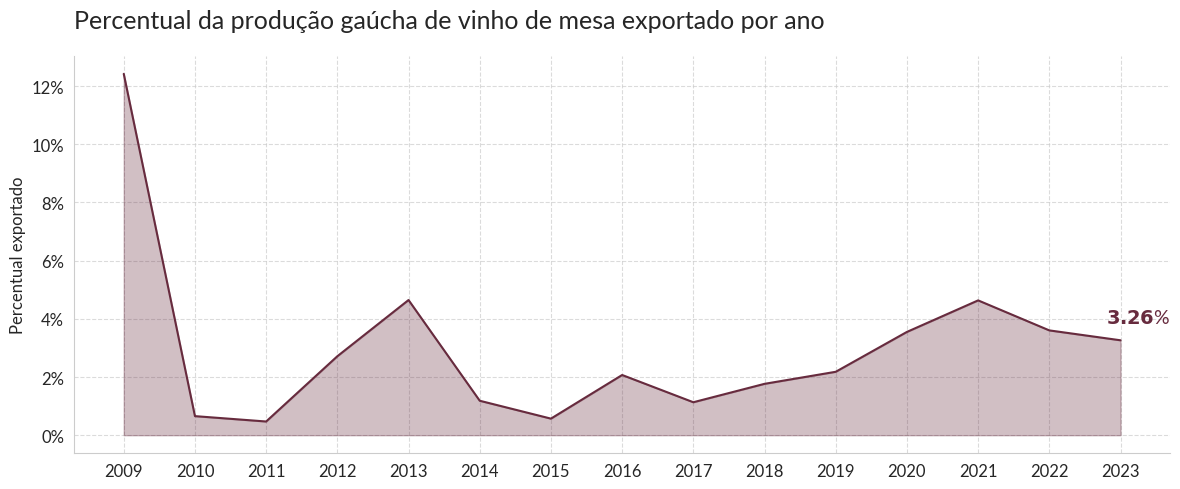

In [18]:
df_comparativo_15anos = df_comparativo.tail(15)
ax = sns.lineplot(data=df_comparativo_15anos, x='ano', y='perc_exportado', color=paleta_monocromatica['bordo'])

# Preenchimento da área
ax.fill_between(df_comparativo_15anos['ano'], df_comparativo_15anos['perc_exportado'], alpha=0.3, color=paleta_monocromatica['bordo'])

# Título
plt.title('Percentual da produção gaúcha de vinho de mesa exportado por ano', pad=20)

# Eixo X
ax.set_xlabel('')
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))

# Eixo Y
ax.set_ylabel('Percentual exportado')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}%'))

# Texto 2023
ax.text(x=df_comparativo_15anos['ano'].iloc[-1] - 0.2, y=df_comparativo_15anos['perc_exportado'].iloc[-1] + 0.6,
        s=f"$\\bf{df_comparativo_15anos['perc_exportado'].iloc[-1]:.2f}$%",
        fontsize=14, linespacing=1.6, color=paleta_monocromatica['bordo'], ha='left')

plt.grid(linestyle='--', alpha=0.7)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

In [19]:
per_exportado_ano_max = round(df_comparativo[df_comparativo['ano'] == df_comparativo['ano'].max()]['perc_exportado'].iloc[0], 2)

print(f"Em {df_comparativo['ano'].max()}, o Rio Grande do Sul exportou apenas {per_exportado_ano_max}% do vinho de mesa que produziu")

Em 2023, o Rio Grande do Sul exportou apenas 3.26% do vinho de mesa que produziu


### Comparativo com cenário nacional e internacional

Com base nas informações da OIV, podemos fazer comparação da exportação de vinho do Rio Grande do Sul com a exportação do Brasil e do mundo. Assim, teremos uma ideia do posicionamento do vinho gaúcho no cenário nacional e internacional.

In [ ]:
# Importar base com informações do mercado mundial de vinho
df_mundial = pd.read_csv('data/processed/oiv-vinho-1995-2024-tratado.csv')
df_mundial.head()

,continent,country,variable,year,quantidade_litro
0,Asia,Afghanistan,Consumption,1995,0
1,Asia,Afghanistan,Imports,1995,0
2,Asia,Afghanistan,Production,1995,0
3,Asia,Afghanistan,Consumption,1996,0
4,Asia,Afghanistan,Imports,1996,0


In [21]:
# Agrupar exportação do Brasil por ano
df_brasil = df_mundial.query('country == "Brazil" and variable == "Exports"').copy()
df_brasil = df_brasil.groupby('year')['quantidade_litro'].sum().reset_index()
df_brasil = df_brasil.rename(columns={'quantidade_litro': 'exportado_br_litros', 'year': 'ano'})

In [22]:
# Mesclar com dataframe de exportação ano
df_comparativo = pd.merge(df_brasil, df_export_ano, on='ano', how='inner')

# Calcular percentual exportado
df_comparativo['perc_exportado'] = (df_comparativo['exportado_rs_litros'] / df_comparativo['exportado_br_litros']) * 100
df_comparativo.tail(2)

,ano,exportado_br_litros,exportado_rs_litros,perc_exportado
27,2022,7800000,7025983,90.076705
28,2023,8000000,5538888,69.236100


In [23]:
# Produção do continente Americano (2009 - 2023)
df_continentes = df_mundial.groupby(['continent', 'year', 'variable'])['quantidade_litro'].sum().reset_index()
df_america = df_continentes.query('continent == "America" and variable == "Production" and year > 2008 and year <= 2023').copy()

df_america['crescimento_quantidade'] = round((df_america['quantidade_litro'].pct_change() * 100), 2)

df_america.head()

,continent,year,variable,quantidade_litro,crescimento_quantidade
179,America,2009,Production,5014200000,NaN
183,America,2010,Production,5190500000,3.52
187,America,2011,Production,5330700000,2.70
191,America,2012,Production,5413300000,1.55
195,America,2013,Production,6019500000,11.20


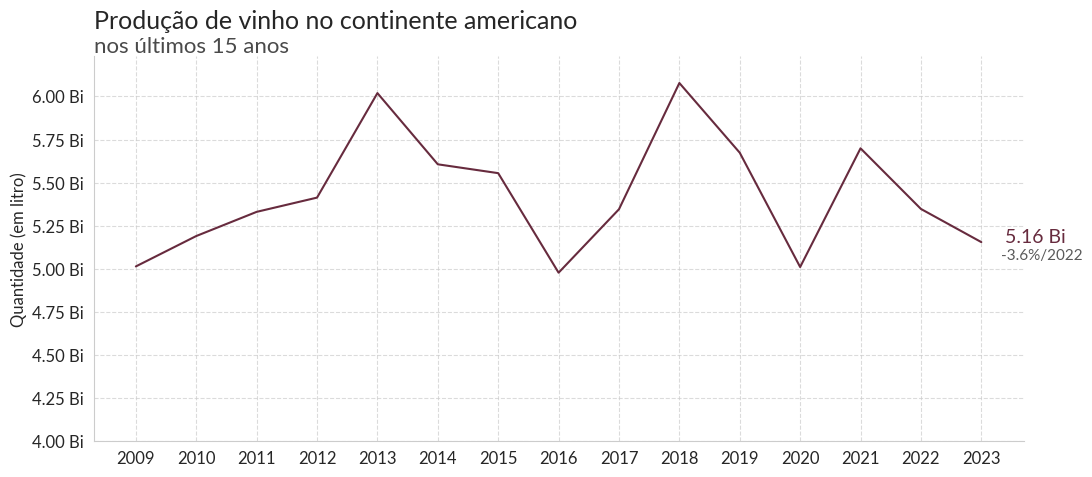

In [24]:
ax = sns.lineplot(data=df_america, x='year', y='quantidade_litro', color=paleta_monocromatica['bordo'])

# Título
ax.set_title('Produção de vinho no continente americano', loc='left', pad=20)
ax.text(0.21, 1, 'nos últimos 15 anos', transform=ax.transAxes, fontsize=16, color=paleta_harmonica['cinza_medio'], ha='right', va='bottom')

# Eixo X
ax.set_xlabel('')
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))

# Eixo Y
ax.set_ylabel('Quantidade (em litro)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e9:,.2f} Bi'))
plt.ylim(4e9, ax.get_ylim()[1] + 1e8)

# Texto 2023
ultimo_ponto = df_america.iloc[-1]
ax.text(x=ultimo_ponto['year'] + 0.9, y=ultimo_ponto['quantidade_litro'], s=f'{ultimo_ponto["quantidade_litro"]/1e9:,.2f} Bi', fontsize=14, color=paleta_monocromatica['bordo'], ha='center')
ax.text(x=ultimo_ponto['year'] + 1, y=ultimo_ponto['quantidade_litro'] - 1e8, s=f'{df_america["crescimento_quantidade"].iloc[-1]}%/2022', fontsize=11, color=paleta_monocromatica['cinza_escuro'], ha='center')

plt.grid(linestyle='--', alpha=0.7)
ax.spines[['top', 'right']].set_visible(False)
plt.show()

## Análise

### Preço médio por litro exportado (USD/L)

Com base na quantidade e no valor de exportação de vinho de mesa informado pela Vitibrasil, medimos quanto, em média, cada país pagou por litro de vinho.

$$ \text{Preço médio} = \frac{\text{Valor exportado}}{\text{Volume exportado}} $$

In [25]:
# Calcular preço médio para cada país, em cada ano
df_export_15anos['preco_medio'] = df_export_15anos['valor'] / df_export_15anos['quantidade']

In [26]:
# Preço médio agrupado por ano
df_export_ano = df_export_15anos.groupby('ano', as_index=False).agg({'valor': 'sum', 'quantidade':'sum', 'preco_medio': 'mean'})
df_export_ano.tail(5)

,ano,valor,quantidade,preco_medio
10,2019,5934826,3152873,4.733134
11,2020,6078288,4409748,3.734633
12,2021,9851942,8058704,3.852291
13,2022,10945282,7025983,4.837118
14,2023,8923076,5538888,4.496822


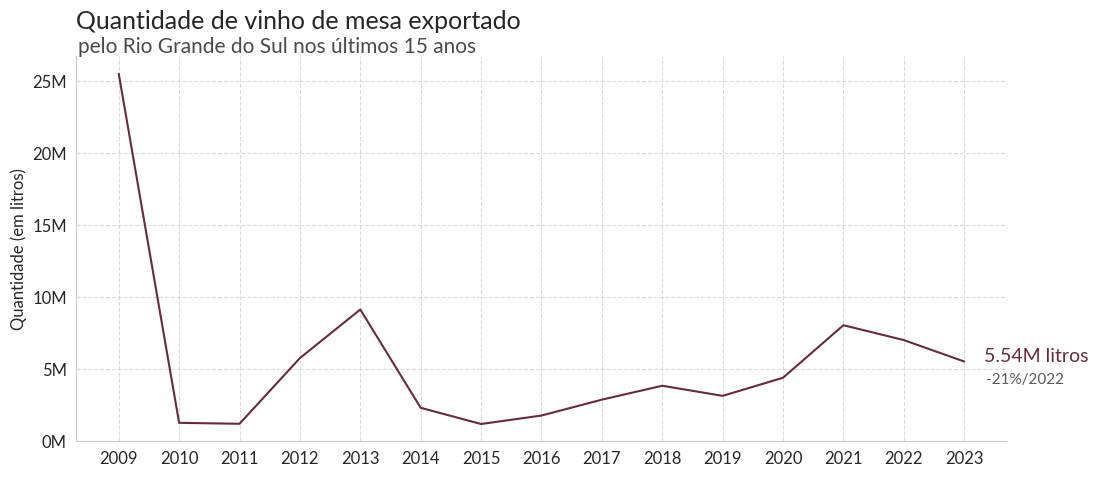

In [27]:
ax = sns.lineplot(data=df_export_ano , x='ano', y='quantidade', color=paleta_monocromatica['bordo'])

# Título
ax.set_title('Quantidade de vinho de mesa exportado', loc='left', pad=20)
ax.text(0.43, 1, 'pelo Rio Grande do Sul nos últimos 15 anos', transform=ax.transAxes, fontsize=15, color=paleta_harmonica['cinza_medio'], ha='right', va='bottom')

# Eixo X
ax.set_xlabel('')
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))

# Eixo Y
ax.set_ylabel('Quantidade (em litros)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:,.0f}M'))
plt.ylim(0, ax.get_ylim()[1] + 1)

# Texto 2023
ultimo_ponto = df_export_ano .iloc[-1]
ax.text(x=ultimo_ponto['ano'] + 1.2, y=ultimo_ponto['quantidade'], s=f'{ultimo_ponto["quantidade"]/1e6:.2f}M litros', fontsize=14, color=paleta_monocromatica['bordo'], ha='center')
ax.text(x=ultimo_ponto['ano'] + 1, y=ultimo_ponto['quantidade'] - 1500000, s=f'-21%/2022', fontsize=11, color=paleta_monocromatica['cinza_escuro'], ha='center')

plt.grid(linestyle='--', alpha=0.7)
ax.spines[['top', 'right']].set_visible(False)
plt.show()

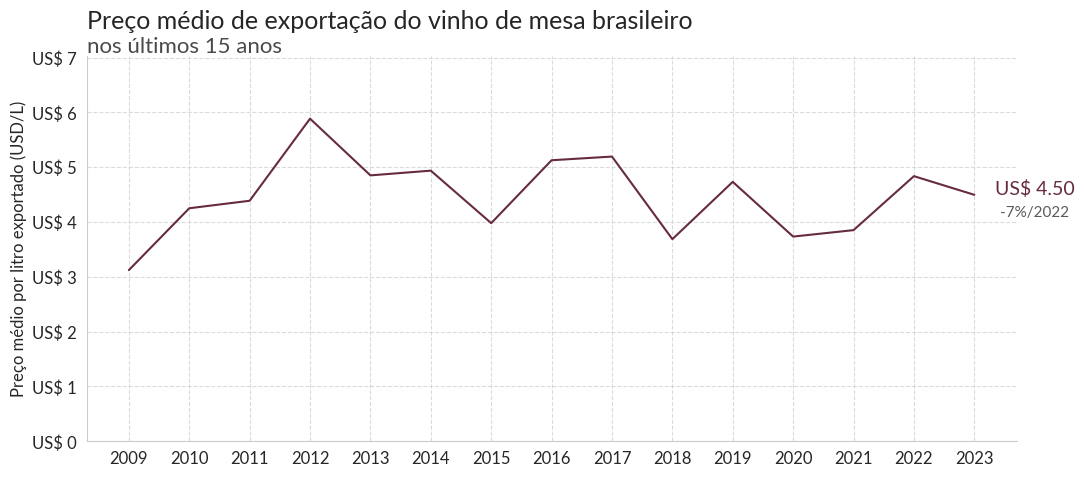

In [28]:
ax = sns.lineplot(data=df_export_ano, x='ano', y='preco_medio', color=paleta_monocromatica['bordo'])

# Título
ax.set_title('Preço médio de exportação do vinho de mesa brasileiro', loc='left', pad=20)
ax.text(0.21, 1, 'nos últimos 15 anos', transform=ax.transAxes, fontsize=16, color=paleta_harmonica['cinza_medio'], ha='right', va='bottom')

# Eixo X
ax.set_xlabel('')
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))

# Eixo Y
ax.set_ylabel('Preço médio por litro exportado (USD/L)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'US$ {x:,.0f}'))
plt.ylim(0, ax.get_ylim()[1] + 1)

# Texto 2023
ultimo_ponto = df_export_ano.iloc[-1]
ax.text(x=ultimo_ponto['ano'] + 1, y=ultimo_ponto['preco_medio'], s=f'US$ {ultimo_ponto["preco_medio"]:.2f}', fontsize=14, color=paleta_monocromatica['bordo'], ha='center')
ax.text(x=ultimo_ponto['ano'] + 1, y=ultimo_ponto['preco_medio'] - 0.4, s=f'-7%/2022', fontsize=11, color=paleta_monocromatica['cinza_escuro'], ha='center')

plt.grid(linestyle='--', alpha=0.7)
ax.spines[['top', 'right']].set_visible(False)
plt.show()

In [29]:
# Agrupar dados de exportação por país
df_export_por_pais = df_export_15anos.groupby(["pais"], as_index=False).agg({
    "iso3": "first",
    "regiao": "first",
    "valor": "sum",
    "quantidade": "sum"
})

# Calcular o preço médio dos últimos 15 anos
df_export_por_pais["preco_medio"] = df_export_por_pais["valor"] / df_export_por_pais["quantidade"]

df_export_por_pais.sort_values(by='preco_medio', ascending=False).head(5)

,pais,iso3,regiao,valor,quantidade,preco_medio
18,Bulgária,BGR,Europa,1610,122,13.196721
10,Bangladesh,BGD,Ásia,133,12,11.083333
31,Croácia,HRV,Europa,607,55,11.036364
15,Bermudas,BMU,América Central e Caribe,153,16,9.562500
68,Letônia,LVA,Europa,3731,395,9.445570


### Variação percentual por ano e país

O **crescimento percentual ano a ano** identifica tendências positivas ou negativas no total exportado. Isso é útil para prever comportamento futuro ou avaliar o impacto de ações comerciais e/ou políticas.

$$\text{Crescimento} = \frac{\text{Valor atual} - \text{Valor anterior}}{\text{Valor anterior}}$$


Ou seja, o resultado é a variação percentual entre o valor atual e o anterior.

In [30]:
# Criando coluna de preço médio para df_export só para ter o crescimento % de 2009 tbm
df_export['preco_medio'] = df_export['valor'] / df_export['quantidade']
df_export_ano = df_export.groupby('ano', as_index=False).agg({'valor': 'sum', 'quantidade':'sum', 'preco_medio': 'mean'})

In [31]:
# Crescimento percentual
df_export_ano['crescimento_valor'] = df_export_ano['valor'].pct_change() * 100
df_export_ano['crescimento_quantidade'] = df_export_ano['quantidade'].pct_change() * 100
df_export_ano['crescimento_preco_medio'] = df_export_ano['preco_medio'].pct_change() * 100
df_export_ano = df_export_ano.tail(15)
df_export_ano.tail()

,ano,valor,quantidade,preco_medio,crescimento_valor,crescimento_quantidade,crescimento_preco_medio
49,2019,5934826,3152873,4.733134,-20.721666,-18.238056,28.340931
50,2020,6078288,4409748,3.734633,2.417291,39.864435,-21.095979
51,2021,9851942,8058704,3.852291,62.084159,82.747495,3.150464
52,2022,10945282,7025983,4.837118,11.097710,-12.814976,25.564700
53,2023,8923076,5538888,4.496822,-18.475595,-21.165650,-7.035107


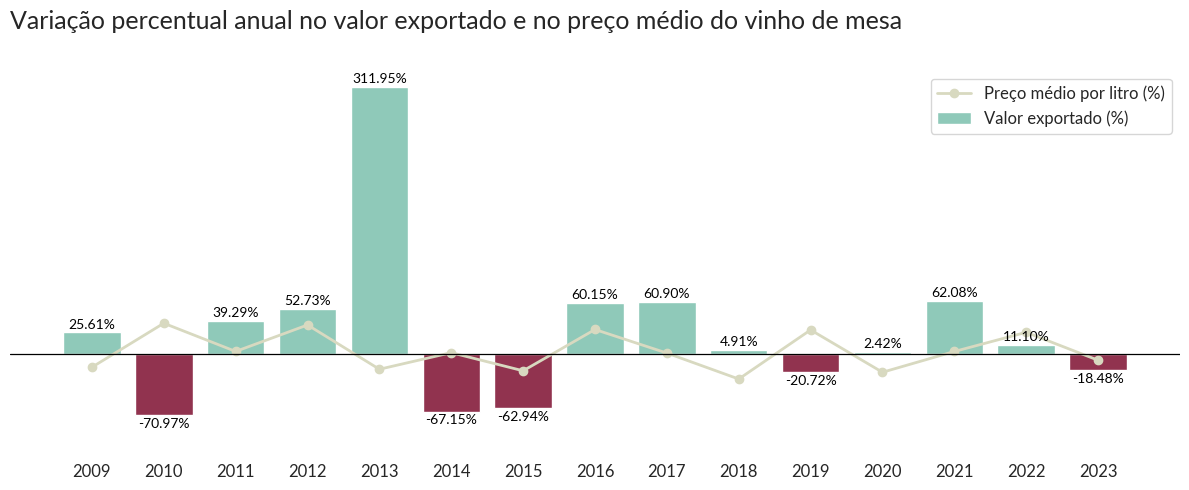

In [32]:
cores = df_export_ano['crescimento_valor'].apply(
    lambda x: paleta_harmonica['azul_claro'] if x > 0 else (
        paleta_harmonica['rosa_escuro'] if x < 0 else paleta_harmonica['cinza_medio']
    )
)

plt.figure(figsize=(12, 5))

# Barras: crescimento do valor
bars = plt.bar(
    df_export_ano['ano'].astype(str),
    df_export_ano['crescimento_valor'],
    color=cores,
    label='Valor exportado (%)'
)

# Anotações nas barras de valor
for bar, valor in zip(bars, df_export_ano['crescimento_valor']):
    if pd.notna(valor):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (2 if valor > 0 else -3),
            f"{valor:.2f}%",
            ha='center',
            va='bottom' if valor > 0 else 'top',
            color='black'
        )


# Linha: crescimento do preço médio
plt.plot(
    df_export_ano['ano'].astype(str),
    df_export_ano['crescimento_preco_medio'],
    color=paleta_harmonica['bege_claro'],
    marker='o',
    linewidth=2,
    label='Preço médio por litro (%)'
)

# # Anotações na linha do preço médio
# for x, y in zip(df_export_ano['ano'].astype(str), df_export_ano['crescimento_preco_medio']):
#     if pd.notna(y):
#         plt.text(
#             x,
#             y + (3 if y >= 0 else -3),  # ajusta a posição do texto acima ou abaixo do ponto
#             f"{y:.2f}%",
#             ha='center',
#             va='bottom' if y >= 0 else 'top',
#             color=paleta_harmonica['bege_claro'],
#             fontsize=9
#         )

# Linha horizontal no 0%
plt.axhline(0, color='black', linewidth=0.9)

# Títulos e layout
plt.title('Variação percentual anual no valor exportado e no preço médio do vinho de mesa', pad=30)
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.box(False)
plt.gca().spines['bottom'].set_position(('outward', 20))
plt.gca().tick_params(axis='x', which='both', length=0)
plt.yticks([])
plt.grid(False)
plt.tight_layout()
plt.show()

Ao analisar variações recentes, será possível identificar mercados em crescimento ou declínio.

In [33]:
# Criar pivot com valores de 2022 e 2023
pivot = df_export_15anos[df_export_15anos['ano'].isin([2022, 2023])].pivot(index='pais', columns='ano', values='valor')

# Calcular variação 2023 vs 2022
pivot['var%2023/2022'] = ((pivot[2023] - pivot[2022]) / pivot[2022]) * 100
pivot.replace([float('inf'), float('-inf')], np.nan, inplace=True)

# Calcular média dos últimos 5 anos (2019–2022)
media_5anos = df_export_15anos[df_export_15anos['ano'].between(2019, 2022)].groupby('pais')['valor'].mean()

# Pegar os valores de 2023 para os mesmos países
valor_2023 = df_export_15anos[df_export_15anos['ano'] == 2023].set_index('pais')['valor']

# Calcular variação 2023 vs média
pivot['var%2023/media_5_anos'] = ((valor_2023 - media_5anos) / media_5anos) * 100

# Resetar índice e deixar só as colunas finais
df_variacao = pivot[['var%2023/2022', 'var%2023/media_5_anos']].reset_index()

# Arredondar as colunas de variação para 2 casas decimais
df_variacao['var%2023/2022'] = df_variacao['var%2023/2022'].round(2)
df_variacao['var%2023/media_5_anos'] = df_variacao['var%2023/media_5_anos'].round(2)

df_variacao = df_variacao.replace([np.inf, -np.inf], np.nan)

df_variacao = df_variacao.sort_values(by='var%2023/2022', ascending=False, na_position='last')
df_variacao.head()

ano,pais,var%2023/2022,var%2023/media_5_anos
34,Dinamarca,254250.00,2097.41
113,Turquia,18870.38,23905.28
109,Taiwan (Formosa),7119.49,507.38
84,Nova Zelândia,4500.64,105.35
38,Equador,1991.43,335.17


In [34]:
print(df_variacao.describe().map(lambda x: f'{x:,.2f}'))

ano   var%2023/2022 var%2023/media_5_anos
count         76.00                100.00
mean       3,820.11                440.73
std       29,205.14              2,454.34
min         -100.00               -100.00
25%          -91.31               -100.00
50%          -33.14                -45.34
75%           42.33                 82.13
max      254,250.00             23,905.28


In [35]:
# Melt para montar o gráfico de caixa
df_box = df_variacao.melt(
    id_vars='pais',
    value_vars=['var%2023/2022', 'var%2023/media_5_anos'],
    var_name='tipo_variacao',
    value_name='valor_variacao'
)

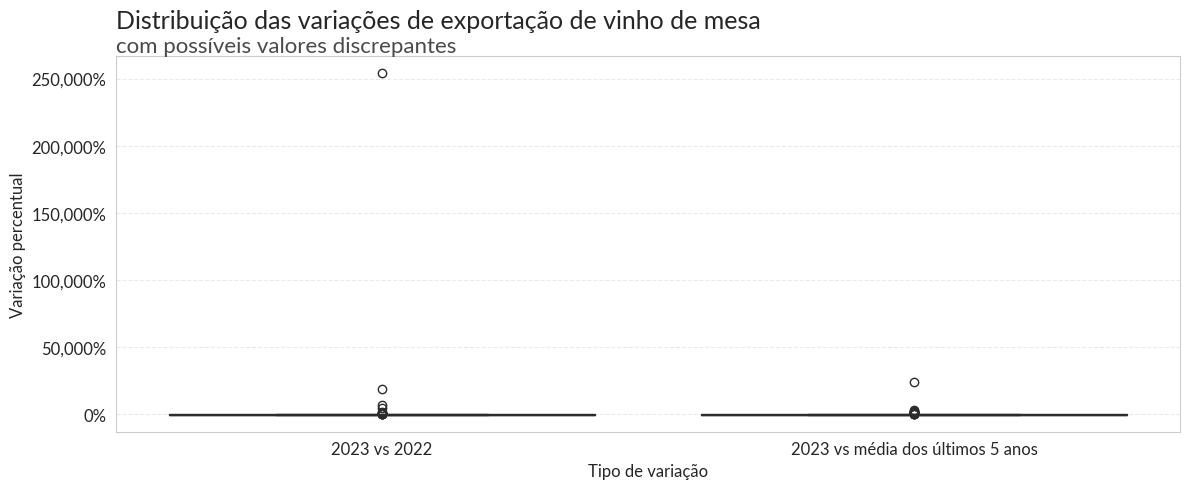

In [36]:
ax = sns.boxplot(data=df_box, x='tipo_variacao', y='valor_variacao', color=paleta_monocromatica['bordo'])

# Título
ax.set_title('Distribuição das variações de exportação de vinho de mesa', pad=20)
ax.text(0.32, 1, 'com possíveis valores discrepantes', transform=ax.transAxes, fontsize=16, color=paleta_harmonica['cinza_medio'], ha='right', va='bottom')

# Eixo X
ax.set_xlabel('Tipo de variação')
ax.set_xticks([0, 1])
ax.set_xticklabels(['2023 vs 2022', '2023 vs média dos últimos 5 anos'])

# Eixo Y
ax.set_ylabel('Variação percentual')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}%'))

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

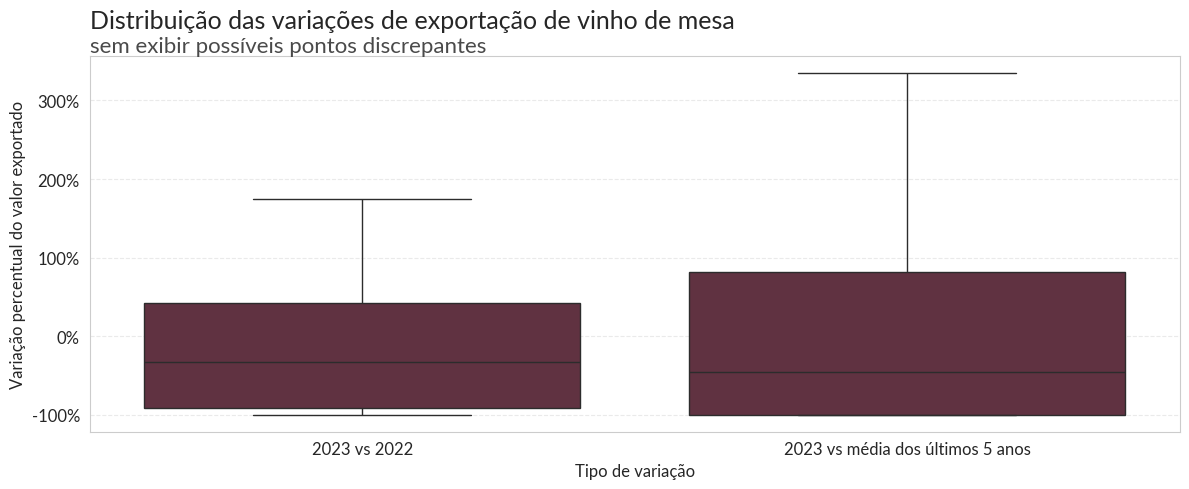

In [37]:
ax = sns.boxplot(data=df_box, x='tipo_variacao', y='valor_variacao', color=paleta_monocromatica['bordo'], showfliers=False)

# Título
ax.set_title('Distribuição das variações de exportação de vinho de mesa', pad=20)
ax.text(0.364, 1, 'sem exibir possíveis pontos discrepantes', transform=ax.transAxes, fontsize=16, color=paleta_harmonica['cinza_medio'], ha='right', va='bottom')

# Eixo X
ax.set_xlabel('Tipo de variação')
ax.set_xticks([0, 1])
ax.set_xticklabels(['2023 vs 2022', '2023 vs média dos últimos 5 anos'])

# Eixo Y
ax.set_ylabel('Variação percentual do valor exportado')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}%'))

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

A maioria dos países teve queda nas importações em 2023, tanto em relação a 2022 quanto à média dos últimos 5 anos. O segundo bloxplot tem uma distribuição mais espalhada. Isso indica que, comparando com uma média histórica, a queda é mais intensa para a maioria dos países, mas há exceções com forte crescimento.

In [38]:
df_export_por_pais = df_export_por_pais.merge(df_variacao, on='pais', how='left')

### Persistência de mercado

A métrica de **frequência de compra** ajuda a distinguir entre mercados fiéis e compras pontuais e, assim, a focar em relacionamentos comerciais duradouros.

In [39]:
# Contar anos com exportação real de cada país
df_export_por_pais['anos_ativos'] = df_export_por_pais['pais'].map(df_export_15anos.query('quantidade > 0').groupby('pais')['ano'].nunique())
df_export_por_pais.sort_values(by='anos_ativos', ascending=False).head(10)

,pais,iso3,regiao,valor,quantidade,preco_medio,var%2023/2022,var%2023/media_5_anos,anos_ativos
1,Alemanha,DEU,Europa,2148277,648115,3.314654,-29.79,15.64,15
8,Austrália,AUS,Oceania,383533,58413,6.565884,10.29,122.12,15
19,Bélgica,BEL,Europa,1382940,399239,3.463940,-88.89,-93.63,15
26,China,CHN,Ásia,4903695,2574686,1.904580,-54.75,-48.01,15
40,Estados Unidos,USA,América do Norte,9309051,3349299,2.779403,-4.20,-8.63,15
66,Japão,JPN,Ásia,2257163,972341,2.321370,-29.71,-36.64,15
97,República Tcheca,CZE,Europa,295034,49799,5.924496,-66.51,-63.98,15
95,Reino Unido,GBR,Europa,4640935,1150780,4.032860,-38.80,-33.41,15
88,Paraguai,PRY,América do Sul,42862206,30803247,1.391483,-22.90,0.11,15
16,Bolívia,BOL,América do Sul,323078,222368,1.452898,-24.61,101.37,14


Classificação categórica que indique se o país teve baixa, média ou alta frequência de compra nos últimos 15 anos, com base na quantidade de anos em que ele realmente comprou:
* `Baixa` frequência: 1 a 4 anos
* `Média` frequência: 5 a 9 anos
* `Alta` frequência: 10 a 15 anos

In [40]:
def classificar_frequencia(n):
    if n <= 4:
        return 'Baixa'
    elif n <= 9:
        return 'Média'
    else:
        return 'Alta'

df_export_por_pais['frequencia_compra'] = df_export_por_pais['anos_ativos'].apply(classificar_frequencia)

# Frequência de compra por região (e total)
pd.crosstab(df_export_por_pais['regiao'], df_export_por_pais['frequencia_compra'], margins=True)

frequencia_compra,Alta,Baixa,Média,All
regiao,,,,
América Central e Caribe,1,12,9,22
América do Norte,2,0,1,3
América do Sul,3,4,6,13
Europa,14,8,8,30
Oceania,2,7,1,10
África,2,14,4,20
Ásia,6,10,8,24
All,30,55,37,122


In [41]:
df_export_por_pais['anos_ativos'].value_counts()

,count
anos_ativos,
1,28
2,16
6,14
14,10
15,9
5,8
3,7
8,6
7,6


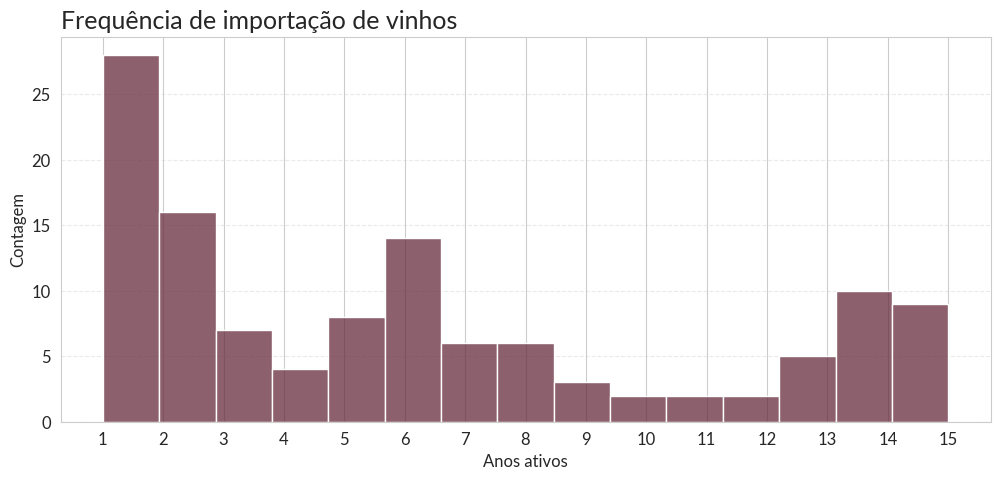

In [42]:
# Histograma de anos ativos
ax = sns.histplot(data=df_export_por_pais, x='anos_ativos', bins=15, color=paleta_monocromatica['bordo'])

# Título
plt.title('Frequência de importação de vinhos')

# Eixo Y
ax.set_ylabel('Contagem')

# Eixo X
ax.set_xlabel('Anos ativos')
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

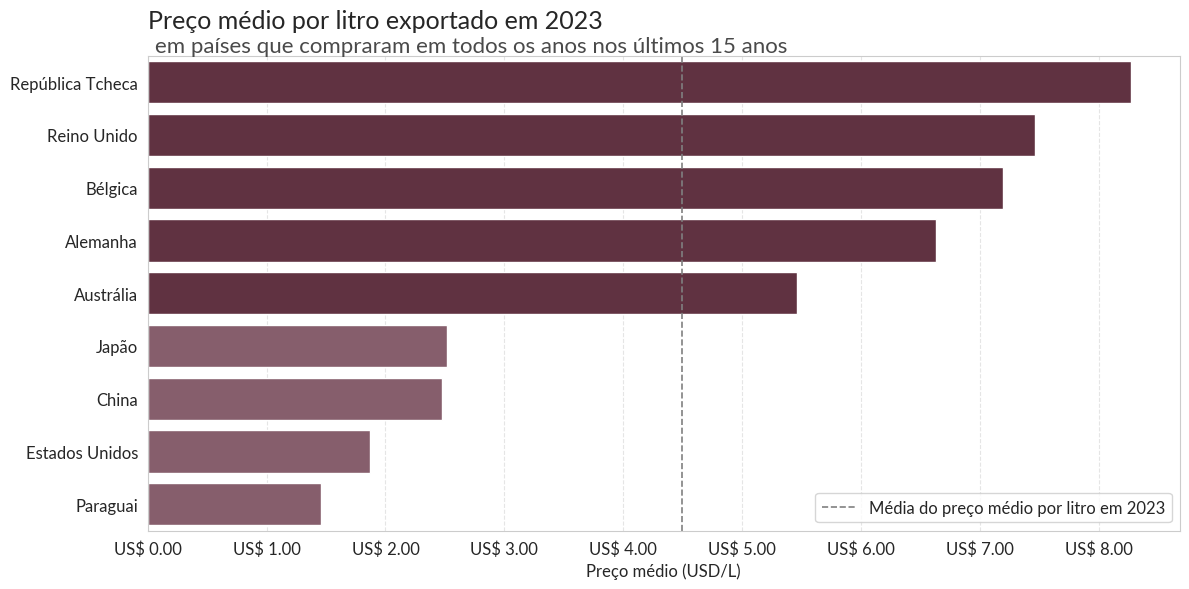

In [43]:
# Média do preço médio em 2023
media_geral_2023 = df_export_15anos[
    (df_export_15anos['ano'] == 2023) &
    (df_export_15anos['quantidade'] > 0)
]['preco_medio'].mean()

# Filtrar apenas os países com frequência alta e ano 2023
anos_ativos_15 = df_export_por_pais.query('anos_ativos == 15')['pais'].unique()
dados_2023 = df_export_15anos[
    (df_export_15anos['pais'].isin(anos_ativos_15)) &
    (df_export_15anos['ano'] == 2023) &
    (df_export_15anos['quantidade'] > 0)
].copy()
dados_2023 = dados_2023.sort_values(by='preco_medio', ascending=False)

# Cores
cores = [paleta_monocromatica['bordo'] if preco > media_geral_2023 else paleta_monocromatica['rosa_escuro'] for preco in dados_2023['preco_medio']]

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=dados_2023, x='preco_medio', y='pais', hue='pais', palette=cores, legend=False)

# Título
ax.set_title('Preço médio por litro exportado em 2023', pad=20)
ax.text(0.62, 1, 'em países que compraram em todos os anos nos últimos 15 anos',
        transform=ax.transAxes, fontsize=16,
        color=paleta_harmonica['cinza_medio'], ha='right', va='bottom')

# Eixo X
ax.set_xlabel('Preço médio (USD/L)')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'US$ {x:,.2f}'))

# Eixo Y
ax.set_ylabel('')

# Linha da média geral
ax.axvline(media_geral_2023, color='gray', linestyle='--', linewidth=1.2, label=f'Média do preço médio por litro em 2023')
ax.legend(loc='lower right')

# Grid e layout
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Paraguai e EUA tem preço médio baixo em relação aos outros países que exportam vinho com frequência do Brasil, ou seja, compram **vinhos baratos**.

In [63]:
fig = px.choropleth(
    df_export_por_pais,
    locations='iso3',
    color='anos_ativos',
    hover_name='pais',
    color_continuous_scale='Purples',
    title='Persistência de mercado'
)
fig.show()

### Participação percentual por país no total exportado

A **participação percentual** mostra a relevância de cada país no total exportado. É uma métrica importante para identificar parceiros prioritários e dependências comerciais.

In [45]:
df_total_geral = df_export_por_pais.sum(numeric_only=True)
df_total_geral

,0
valor,1.144493e+08
quantidade,8.317503e+07
preco_medio,4.350610e+02
var%2023/2022,2.903284e+05
var%2023/media_5_anos,4.407320e+04
anos_ativos,7.440000e+02


In [46]:
df_export_por_pais['%valor'] = (df_export_por_pais['valor'] / df_total_geral['valor']) * 100
df_export_por_pais['%quantidade'] = (df_export_por_pais['quantidade'] / df_total_geral['quantidade']) * 100
df_export_por_pais.sort_values(by='%valor', ascending=False, inplace=True)

In [47]:
# Quanto de mercado ocupam os países com + valor de compra?
print(f'Os 10 primeiros países importadores representam {df_export_por_pais["%valor"].head(10).sum():,.2f}% do valor exportado de vinho, enquanto os demais representam os {100 - df_export_por_pais["%valor"].head(10).sum():,.2f}% restantes.')

Os 10 primeiros países importadores representam 86.76% do valor exportado de vinho, enquanto os demais representam os 13.24% restantes.


In [48]:
# Países de alta frequência de compra com maior porcentagem de valor exportado nos últimos 15 anos
paises_alta_freq = df_export_por_pais[df_export_por_pais['frequencia_compra'] == 'Alta']['pais'].unique()
top_participacao = df_export_por_pais[df_export_por_pais['pais'].isin(paises_alta_freq)].sort_values(by='%valor', ascending=False)
top_participacao.head(10)[['pais', 'regiao', 'valor', 'quantidade', '%valor', '%quantidade']]

,pais,regiao,valor,quantidade,%valor,%quantidade
88,Paraguai,América do Sul,42862206,30803247,37.450827,37.034249
40,Estados Unidos,América do Norte,9309051,3349299,8.133778,4.026808
26,China,Ásia,4903695,2574686,4.284601,3.095504
95,Reino Unido,Europa,4640935,1150780,4.055014,1.383564
89,Países Baixos,Europa,3012934,897986,2.632549,1.079634
66,Japão,Ásia,2257163,972341,1.972195,1.169030
1,Alemanha,Europa,2148277,648115,1.877056,0.779218
19,Bélgica,Europa,1382940,399239,1.208343,0.479999
23,Canadá,América do Norte,1059120,186081,0.925405,0.223722
104,Suíça,Europa,718710,101010,0.627972,0.121443


### Classificação dos países por consumo proporcional

Utilizando os dados da população mundial, vamos criar a métrica de **litros por mil habitantes** (penetração proporcional) para medir o engajamento real da população com o vinho brasileiro. Ideal para identificar mercados com alta receptividade.

$$ \text{Litros por mil habitantes} = \left( \frac{\text{Volume exportado}}{\text{População}} \right) \times 1000 $$

In [ ]:
df_populacao = pd.read_csv('data/raw/API_SP.POP.TOTL_DS2_en_csv_v2_85220.csv', skiprows=3)
df_populacao.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54922.0,55578.0,56320.0,57002.0,57619.0,58190.0,...,108727.0,108735.0,108908.0,109203.0,108587.0,107700.0,107310.0,107359.0,NaN,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130072080.0,133534923.0,137171659.0,140945536.0,144904094.0,149033472.0,...,623369401.0,640058741.0,657801085.0,675950189.0,694446100.0,713090928.0,731821393.0,750503764.0,NaN,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,9035043.0,9214083.0,9404406.0,9604487.0,9814318.0,10036008.0,...,34700612.0,35688935.0,36743039.0,37856121.0,39068979.0,40000412.0,40578842.0,41454761.0,NaN,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97630925.0,99706674.0,101854756.0,104089175.0,106388440.0,108772632.0,...,429454743.0,440882906.0,452195915.0,463365429.0,474569351.0,485920997.0,497387180.0,509398589.0,NaN,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5231654.0,5301583.0,5354310.0,5408320.0,5464187.0,5521981.0,...,29183070.0,30234839.0,31297155.0,32375632.0,33451132.0,34532429.0,35635029.0,36749906.0,NaN,NaN


In [50]:
df_populacao = df_populacao[['Country Name', 'Country Code', '2023']]
df_populacao = df_populacao.rename(columns={'2023': 'populacao'})
df_populacao.head()

,Country Name,Country Code,populacao
0,Aruba,ABW,107359.0
1,Africa Eastern and Southern,AFE,750503764.0
2,Afghanistan,AFG,41454761.0
3,Africa Western and Central,AFW,509398589.0
4,Angola,AGO,36749906.0


In [51]:
df_export_15anos = df_export_15anos.merge(df_populacao[['Country Code', 'populacao']], left_on='iso3', right_on='Country Code', how='left')
df_export_15anos = df_export_15anos.drop(columns='Country Code')

In [52]:
# Dados de população faltantes
pop_extra = pd.DataFrame({
    'iso3': ['AIA', 'ANT', 'CCK', 'GUF', 'MTQ', 'PCN', 'TKL', 'TWN'],
    'populacao': [19079, 175653, 593, 303401, 366981, 35, 2593, 23317145]
})

# Atualiza população com base no código ISO3
df_export_15anos = df_export_15anos.merge(pop_extra, on='iso3', how='left', suffixes=('', '_extra'))
df_export_15anos['populacao'] = df_export_15anos['populacao'].fillna(df_export_15anos['populacao_extra'])
df_export_15anos = df_export_15anos.drop(columns='populacao_extra')

In [53]:
# Calcular litros por habitantes
df_export_15anos['litros_por_mil_hab'] = (df_export_15anos['quantidade'] / df_export_15anos['populacao']) * 1000
df_export_15anos.tail(5)

,pais,ano,quantidade,valor,regiao,iso3,preco_medio,populacao,litros_por_mil_hab
1825,Índia,2019,51,273,Ásia,IND,5.352941,1.438070e+09,0.000035
1826,Índia,2020,7,10,Ásia,IND,1.428571,1.438070e+09,0.000005
1827,Índia,2021,13,86,Ásia,IND,6.615385,1.438070e+09,0.000009
1828,Índia,2022,247,1021,Ásia,IND,4.133603,1.438070e+09,0.000172
1829,Índia,2023,60,170,Ásia,IND,2.833333,1.438070e+09,0.000042


In [54]:
# Média de litros por habitantes dos últimos 15 anos
df_consumo = df_export_15anos.groupby('pais')['litros_por_mil_hab'].mean().reset_index().sort_values(by='litros_por_mil_hab', ascending=False)
df_consumo.rename(columns={'litros_por_mil_hab': 'media_litros_por_mil_hab'}, inplace=True)
df_consumo.head(10)

,pais,media_litros_por_mil_hab
88,Paraguai,300.044710
33,Curaçao,97.502626
61,Ilhas Marshall,64.851778
3,Antilhas Holandesas,30.007648
115,Uruguai,22.012225
91,Pitcairn,20.952381
98,Rússia,15.213805
54,Haiti,13.469380
70,Luxemburgo,5.353500
89,Países Baixos,3.348735


In [55]:
df_consumo['media_litros_por_mil_hab'].describe()

,media_litros_por_mil_hab
count,122.000000
mean,5.169981
std,29.156228
min,0.000003
25%,0.004226
50%,0.164073
75%,1.100811
max,300.044710


Classificação categórica do consumo proporcional será dividida em 3 partes:
* Primeira faixa: do menor valor até o 33,3º percentil
* Segunda faixa: do 33,3º ao 66,6º percentil
* Terceira faixa: do 66,6º percentil até o maior valor

In [56]:
df_consumo['faixa_consumo'], limites = pd.qcut(
    df_consumo['media_litros_por_mil_hab'],
    q=3,
    labels=['Baixa', 'Média', 'Alta'],
    retbins=True
)
print(f'Limites de cada faixa: {limites}')

Limites de cada faixa: [3.31922583e-06 2.28496152e-02 5.20004618e-01 3.00044710e+02]


In [57]:
pop_2023 = df_export_15anos[df_export_15anos['ano'] == 2023][['pais', 'populacao']]
df_export_por_pais = df_export_por_pais.merge(pop_2023, on='pais', how='left')
df_export_por_pais = df_export_por_pais.merge(df_consumo, on='pais', how='left')

In [58]:
pd.crosstab(df_export_por_pais['regiao'], df_export_por_pais['faixa_consumo'], margins=True)

faixa_consumo,Baixa,Média,Alta,All
regiao,,,,
América Central e Caribe,7,4,11,22
América do Norte,1,1,1,3
América do Sul,1,7,5,13
Europa,7,10,13,30
Oceania,2,4,4,10
África,9,7,4,20
Ásia,14,7,3,24
All,41,40,41,122


In [59]:
fig = px.choropleth(
    df_export_por_pais,
    locations='iso3',
    color='faixa_consumo',
    hover_name='pais',
    color_discrete_map={
    'Baixa': paleta_harmonica['rosa_escuro'],
    'Média': paleta_harmonica['bege_claro'],
    'Alta': paleta_harmonica['azul_claro']
},
    title='Penetração proporcional do vinho brasileiro (litros por mil habitantes)'
)

fig.show()

### Crescimento econômico dos países importadores

Agora, vamos explorar o crescimento anual do PIB dos países que compraram vinho de mesa do Rio Grande do Sul nos últimos 15 anos.

In [ ]:
# Importar base de crescimento anual do PIB do Banco Mundial
df_pib = pd.read_csv('data/raw/API_NY.GDP.MKTP.KD.ZG_DS2_en_csv_v2_85160.csv', sep = ',', skiprows= 4)
df_pib.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,1.719625,7.048533,2.397085,-2.232440,-26.211821,24.132627,8.517918,4.263719,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,0.468736,7.869709,5.622374,4.690458,5.159574,...,2.194761,2.684543,2.666632,2.194319,-2.864293,4.576393,3.553878,2.320138,NaN,NaN
2,Afghanistan,AFG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.260314,2.647003,1.189228,3.911603,-2.351101,-20.738839,-6.240172,2.710887,NaN,NaN
3,Africa Western and Central,AFW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,1.873054,3.712777,7.111968,5.413943,4.120855,...,0.160782,2.289810,2.844755,3.232903,-1.003994,4.037630,3.789680,3.354733,NaN,NaN
4,Angola,AGO,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.580050,-0.147213,-1.316362,-0.702273,-5.638215,1.199211,3.044727,1.001289,NaN,NaN


In [61]:
df_pib = df_pib[['Country Name', 'Country Code', '2023']]
df_pib = df_pib.rename(columns={'2023': 'crescimento%pib_2023'})
df_pib.sort_values(by='crescimento%pib_2023', ascending=False).head(5)

,Country Name,Country Code,crescimento%pib_2023
146,"Macao SAR, China",MAC,75.061377
94,Guyana,GUY,33.802617
49,Caribbean small states,CSS,12.557635
132,Libya,LBY,10.155818
260,Samoa,WSM,8.584091


In [62]:
# Colocando coluna PIB
df_export_por_pais = df_export_por_pais.merge(df_pib[['Country Code', 'crescimento%pib_2023']], left_on='iso3', right_on='Country Code', how='left')
df_export_por_pais = df_export_por_pais.drop(columns='Country Code')

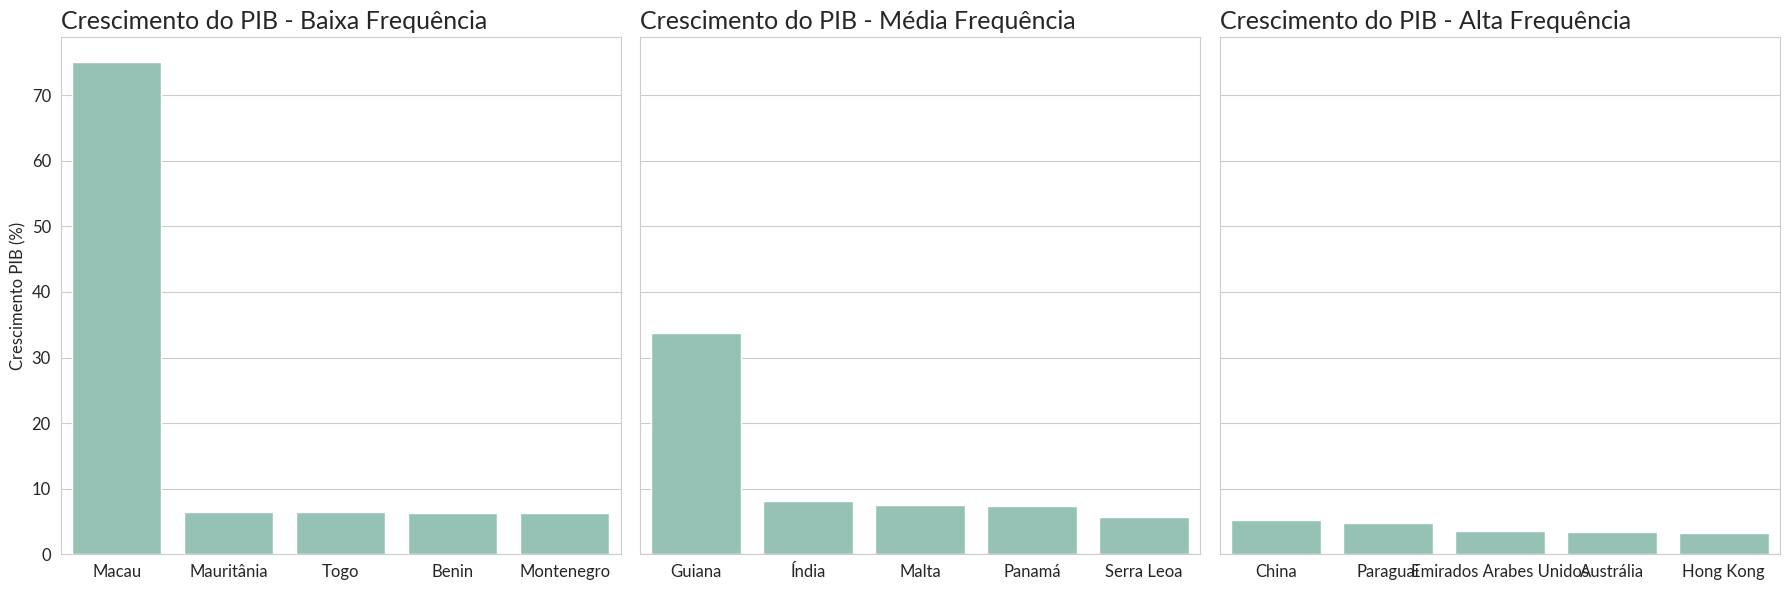

In [66]:
# Filtrar os países com maior crescimento do PIB
top_crescimento = df_export_por_pais.sort_values(by="crescimento%pib_2023", ascending=False)

# Criar figura com 3 subgráficos baseado na frequência de compra
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Criar cada gráfico com top 5 de crescimento PIB
frequencias = top_crescimento["frequencia_compra"].unique()

for i, freq in enumerate(frequencias):
    df_filtrado = top_crescimento[top_crescimento["frequencia_compra"] == freq].head(5)

    sns.barplot(data=df_filtrado, x="pais", y="crescimento%pib_2023", ax=axes[i])
    axes[i].set_title(f"Crescimento do PIB - {freq} Frequência")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Crescimento PIB (%)")

plt.tight_layout()
plt.show()

In [68]:
# Calculando limite inferior e superior da variação de compra entre 2023/2022
Q1 = df_export_por_pais['var%2023/2022'].quantile(.25)
Q3 = df_export_por_pais['var%2023/2022'].quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ

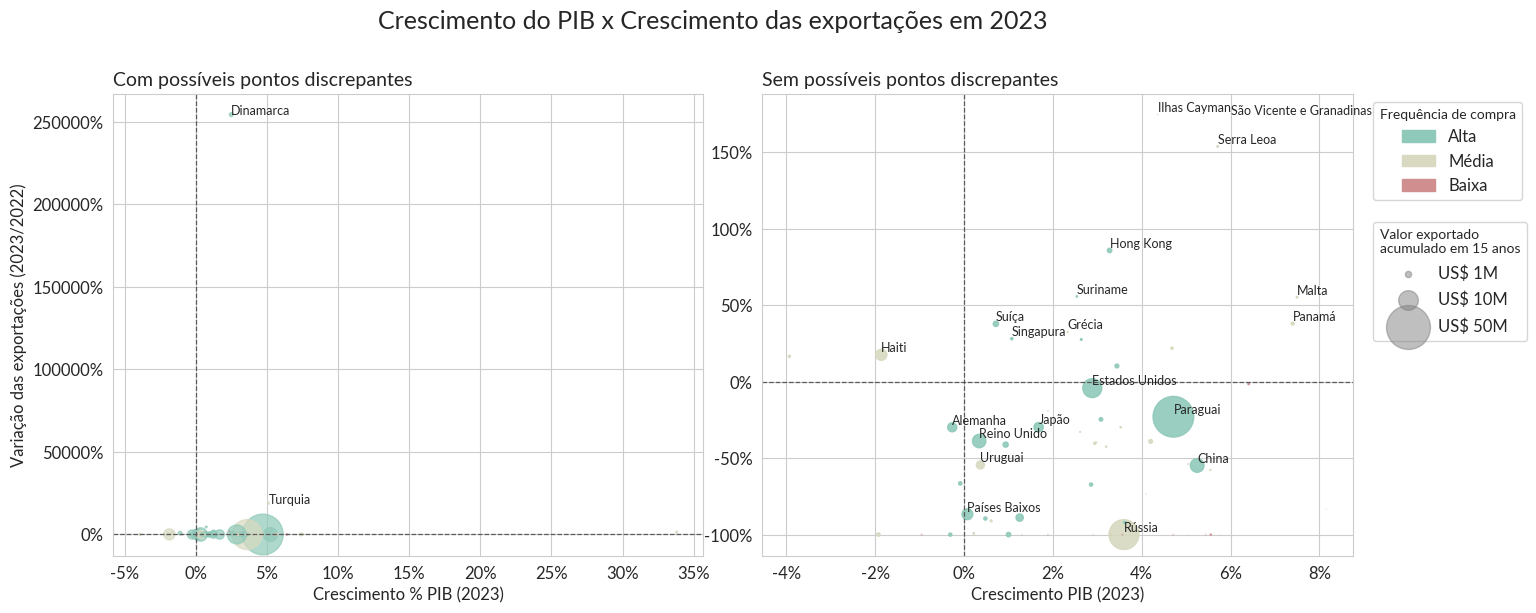

In [72]:
# Separar outliers com base em percentil de variação de exportação
dados_com = df_export_por_pais.copy()
dados_sem = df_export_por_pais[df_export_por_pais['var%2023/2022'] < limite_superior]

# Paleta de cores por frequencia_compra
frequencia_compras = df_export_por_pais['frequencia_compra'].unique()
palette = dict(zip(frequencia_compras, list(paleta_harmonica.values())[:4]))

# Identificar cores
colors_com = dados_com['frequencia_compra'].map(palette)
colors_sem = dados_sem['frequencia_compra'].map(palette)

# Top países por valor exportado (para anotação)
top_paises_com = dados_com.sort_values(by='var%2023/2022', ascending=False).head(2)
top_crescimento = dados_sem.sort_values(by='var%2023/2022', ascending=False).head(10)
top_valor = dados_sem.sort_values(by='valor', ascending=False).head(10)
top_paises_sem = pd.concat([top_crescimento, top_valor])

# Criar figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle('Crescimento do PIB x Crescimento das exportações em 2023', fontsize=18, y=1.02)

# --- Gráfico com outliers ---
ax1.scatter(
    dados_com['crescimento%pib_2023'],
    dados_com['var%2023/2022'],
    s=dados_com['valor'] / 5e4,
    alpha=0.7,
    c=colors_com
)
ax1.axhline(0, color=paleta_monocromatica['cinza_escuro'], linestyle='--', linewidth=0.9)
ax1.axvline(0, color=paleta_monocromatica['cinza_escuro'], linestyle='--', linewidth=0.9)
ax1.set_title('Com possíveis pontos discrepantes', fontsize=14)
ax1.set_xlabel('Crescimento % PIB (2023)')
ax1.set_ylabel('Variação das exportações (2023/2022)')

for _, row in top_paises_com.iterrows():
    ax1.text(row['crescimento%pib_2023'], row['var%2023/2022'] + 2, row['pais'], fontsize=9)

# --- Gráfico sem outliers ---
ax2.scatter(
    dados_sem['crescimento%pib_2023'],
    dados_sem['var%2023/2022'],
    s=dados_sem['valor'] / 5e4,
    alpha=0.9,
    c=colors_sem
)
ax2.axhline(0, color=paleta_monocromatica['cinza_escuro'], linestyle='--', linewidth=0.9)
ax2.axvline(0, color=paleta_monocromatica['cinza_escuro'], linestyle='--', linewidth=0.9)
ax2.set_title('Sem possíveis pontos discrepantes', fontsize=14)
ax2.set_xlabel('Crescimento PIB (2023)')
ax2.set_ylabel('')

for _, row in top_paises_sem.iterrows():
    ax2.text(row['crescimento%pib_2023'], row['var%2023/2022'] + 2, row['pais'], fontsize=9)

# Formatadores
percent_formatter = ticker.FuncFormatter(lambda x, _: f'{x:.0f}%')
ax1.yaxis.set_major_formatter(percent_formatter)
ax2.yaxis.set_major_formatter(percent_formatter)
ax1.xaxis.set_major_formatter(percent_formatter)
ax2.xaxis.set_major_formatter(percent_formatter)

# Legenda por frequencia_compra
handles_frequencia_compra = [
    mpatches.Patch(color=palette[seg], label=seg) for seg in frequencia_compras
]
legenda_frequencia_compra = ax2.legend(
    handles=handles_frequencia_compra,
    title='Frequência de compra',
    loc='upper left',
    bbox_to_anchor=(1.02, 1)
)
ax2.add_artist(legenda_frequencia_compra)

# Legenda de tamanhos (valor exportado)
handles_tamanho = [
    ax2.scatter([], [], s=valor / 5e4, c='gray', alpha=0.5, label=f'US$ {valor/1e6:.0f}M')
    for valor in [1e6, 1e7, 5e7]
]
legenda_tamanho = ax2.legend(
    handles=handles_tamanho,
    title='Valor exportado\nacumulado em 15 anos',
    loc='upper left',
    labelspacing=0.6,
    bbox_to_anchor=(1.02, 0.74)
)

plt.subplots_adjust(right=0.9, wspace=0.1)
plt.show()

* Quadrante 1 – Superior Direito (+ PIB, + exportações)
  * Países com crescimento econômico e aumento nas importações de vinho do Brasil
  * Podem representar bons mercados em expansão.
  * Merecem atenção, mesmo que a frequência de compra ainda seja baixa
* Quadrante 2 – Superior Esquerdo (- PIB, + exportações)
  * A economia está em retração, mas as compras de vinho brasileiro aumentaram.
  * Pode ser uma oportunidade de curto prazo, com risco atrelado à instabilidade econômica
* Quadrante 3 – Inferior Esquerdo (- PIB, - exportações)
  * Economia em retração e queda nas compras
  * Em geral, não são prioridade no curto prazo
* Quadrante 4 – Inferior Direito (+ PIB, - exportações)
  * Economias em crescimento, mas redução nas importações de vinho brasileiro
  * Merecem atenção estratégica para retomar participação


## Segmentação de perfil

Agora, faremos algumas segmentações por perfil, levando em conta as métricas construídas anteriormente.

In [ ]:
media_volume = df_export_por_pais['quantidade'].mean()
media_volume

np.float64(681762.2704918033)

### Mercados fiéis

Quais são os mercados consolidados que o Brasil deve manter o relacionamento?

* Alta penetração
* Alta frequência de compra
* Volume exportado acima da média

O ideal seria melhorar preco/litro e monitorar variação de crescimento para evitar queda

In [ ]:
mercados_fieis = df_export_por_pais.query('faixa_consumo == "Alta" and frequencia_compra == "Alta" and quantidade > @media_volume')
mercados_fieis[['pais', 'preco_medio', '%valor', '%quantidade', 'anos_ativos', 'media_litros_por_mil_hab', 'var%2023/2022', 'var%2023/media_5_anos', 'crescimento%pib_2023']]

,pais,preco_medio,%valor,%quantidade,anos_ativos,media_litros_por_mil_hab,var%2023/2022,var%2023/media_5_anos,crescimento%pib_2023
0,Paraguai,1.391483,37.450827,37.034263,15,300.044710,-22.90,0.11,4.714124
2,Estados Unidos,2.779403,8.133778,4.026810,15,0.666697,-4.20,-8.63,2.887556
4,Reino Unido,4.032860,4.055014,1.383565,15,1.122438,-38.80,-33.41,0.339966
7,Países Baixos,3.355213,2.632549,1.079635,14,3.348735,-86.69,-89.84,0.074561
8,Japão,2.321370,1.972195,1.169030,15,0.520595,-29.71,-36.64,1.679020


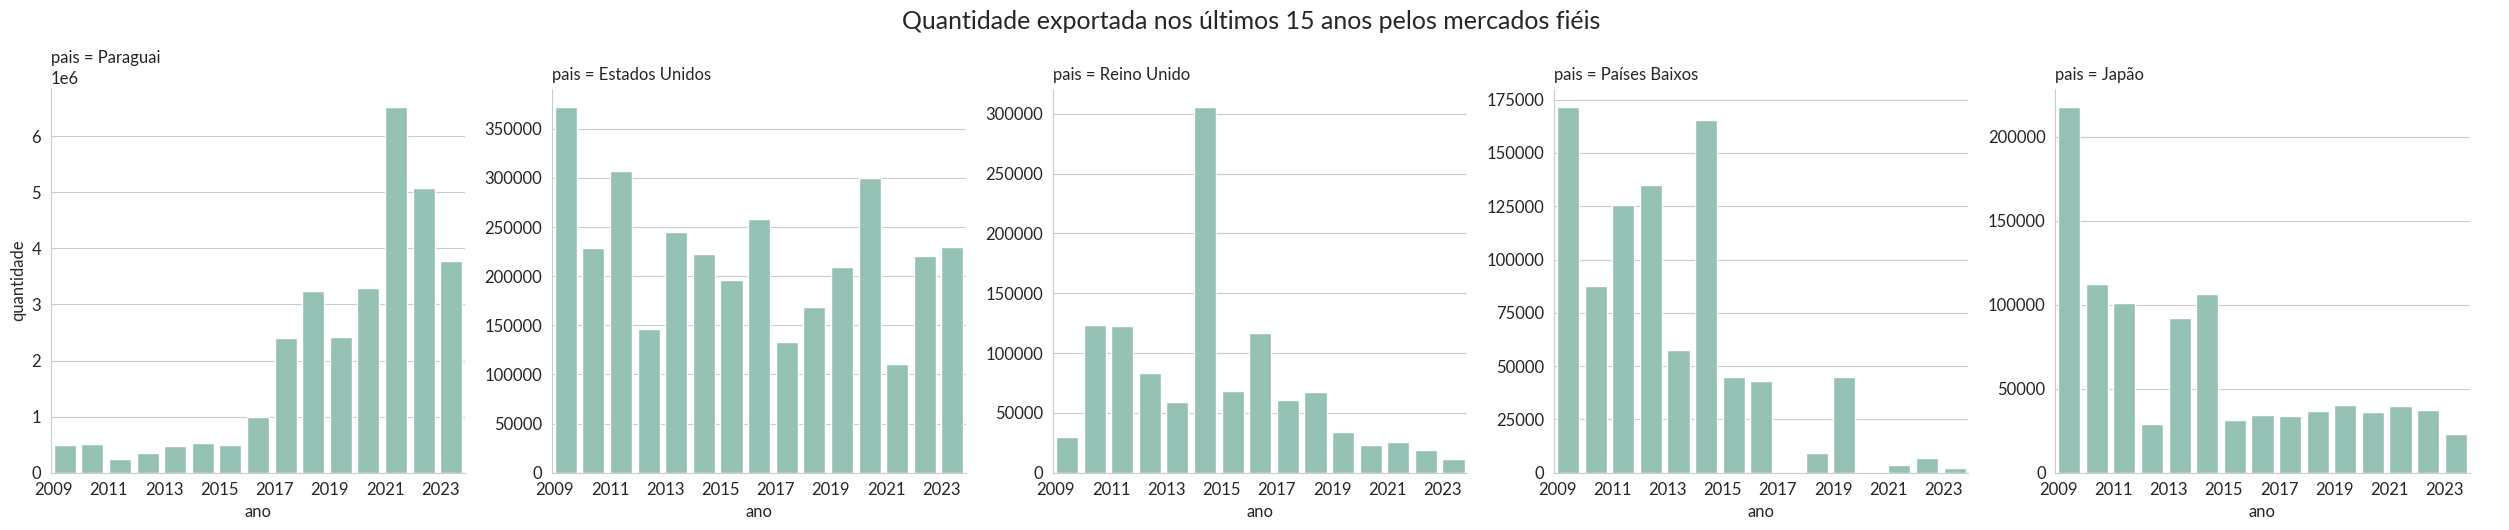

In [ ]:
lista_mercados_fieis = mercados_fieis['pais'].unique()
df_export_15anos_mercados_fieis = df_export_15anos[df_export_15anos['pais'].isin(lista_mercados_fieis)].copy()

ax = sns.catplot(data=df_export_15anos_mercados_fieis, x='ano', y='quantidade', col='pais', col_order=lista_mercados_fieis, kind='bar', sharey=False)
plt.suptitle('Quantidade exportada nos últimos 15 anos pelos mercados fiéis', fontsize=18, y=1.05)

for ax_single in ax.axes.flat:
    ax_single.xaxis.set_major_locator(ticker.IndexLocator(base=2, offset=0))

plt.show()

### Mercados com potencial de expansão

Onde o Brasil já tem bom espaço e poderia crescer mais?

* Alta penetração
* Alta frequência de compra
* Volume exportado abaixo da média
* Crescimento positivo recente (PIB e importação de vinho)

Esses são mercados bons com potencial de expansão.

In [ ]:
potencial_expansao = df_export_por_pais.query('faixa_consumo == "Alta" and frequencia_compra == "Alta" and quantidade < @media_volume and `var%2023/media_5_anos` > 0 and `crescimento%pib_2023` > 0').sort_values(by='var%2023/2022', ascending=False)
potencial_expansao[['pais', 'preco_medio', '%valor', 'anos_ativos', 'media_litros_por_mil_hab', '%quantidade', 'var%2023/2022', 'var%2023/media_5_anos', 'crescimento%pib_2023']]

,pais,preco_medio,%valor,anos_ativos,media_litros_por_mil_hab,%quantidade,var%2023/2022,var%2023/media_5_anos,crescimento%pib_2023
21,Dinamarca,4.726815,0.327596,14,0.889195,0.095365,254250.00,2097.41,2.495184
15,Portugal,1.506327,0.505716,12,2.421577,0.461963,508.31,17.86,2.526281
18,Hong Kong,3.138613,0.446887,14,1.441568,0.195921,85.84,75.79,3.276526
56,Suriname,1.706135,0.043687,14,3.106657,0.035234,55.80,41.01,2.539567
13,Suíça,7.115236,0.627972,13,0.757643,0.121443,37.87,36.49,0.716067
46,Bahamas,5.439187,0.073421,10,2.578443,0.018574,27.64,72.21,2.639056
24,Bolívia,1.452898,0.282289,14,1.210743,0.267350,-24.61,101.37,3.081965


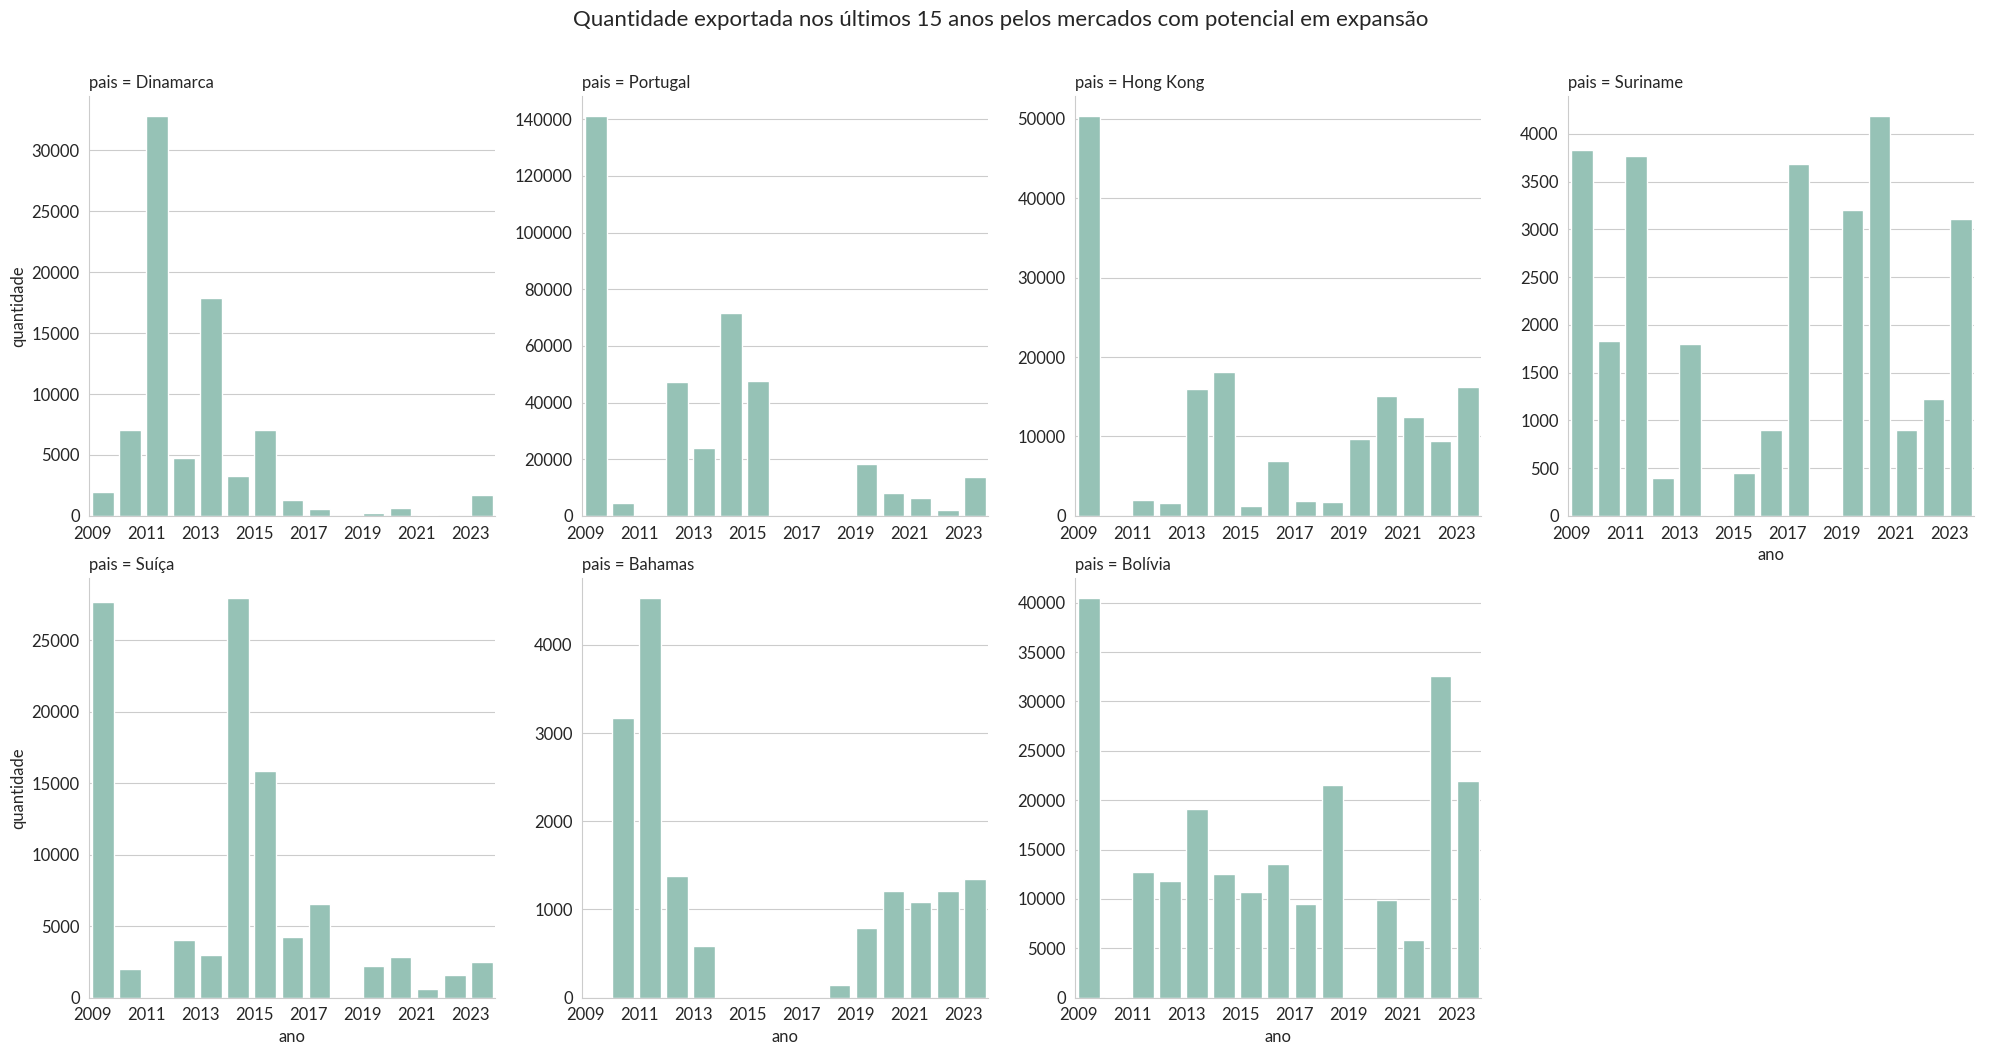

In [ ]:
lista_potencial_expansao = potencial_expansao['pais'].unique()
df_export_15anos_potencial_expansao = df_export_15anos[df_export_15anos['pais'].isin(lista_potencial_expansao)].copy()

ax = sns.catplot(data=df_export_15anos_potencial_expansao, x='ano', y='quantidade', col='pais', col_order=lista_potencial_expansao, col_wrap=4, kind='bar', sharey=False, sharex=False)
plt.suptitle('Quantidade exportada nos últimos 15 anos pelos mercados com potencial em expansão', fontsize=16, y=1.05)

for ax_single in ax.axes.flat:
    ax_single.xaxis.set_major_locator(ticker.IndexLocator(base=2, offset=0))

plt.show()

O caso mais atípico é o da Dinamarca, que teve uma explosão pontual nas compras de vinho brasileiro em 2023 (+254 mil % em relação ao ano anterior). Esse país é um outlier e talvez deve ser considerado, na verdade, um mercado oportunista.

### Mercados oportunistas

Onde é só uma compra pontual, mesmo com volume alto?

* Frequência baixa
* Volume acima da média

Aqui, o Brasil fez uma venda significativa, mas sem recorrência. Mercado oportunista ou instável.

Nesse caso, não havia nenhum com a frequência baixa, estão pegamos com a frequência média.

In [ ]:
mercados_oportunistas = df_export_por_pais.query('(frequencia_compra == "Baixa" or frequencia_compra == "Média") and quantidade > @media_volume')
mercados_oportunistas[['pais', 'preco_medio', '%valor', '%quantidade', 'anos_ativos', 'media_litros_por_mil_hab', 'var%2023/2022', 'var%2023/media_5_anos', 'crescimento%pib_2023']]

,pais,preco_medio,%valor,%quantidade,anos_ativos,media_litros_por_mil_hab,var%2023/2022,var%2023/media_5_anos,crescimento%pib_2023
1,Rússia,0.705369,20.228798,39.461548,8,15.213805,-100.00,-100.00,3.600000
5,Espanha,1.912278,3.325393,2.392832,7,2.744328,NaN,1028.06,2.675663
6,Haiti,1.360501,2.794992,2.826845,8,13.469380,17.63,60.44,-1.863884
10,Uruguai,1.496529,1.462787,1.344981,9,22.012225,-54.45,55.88,0.367475


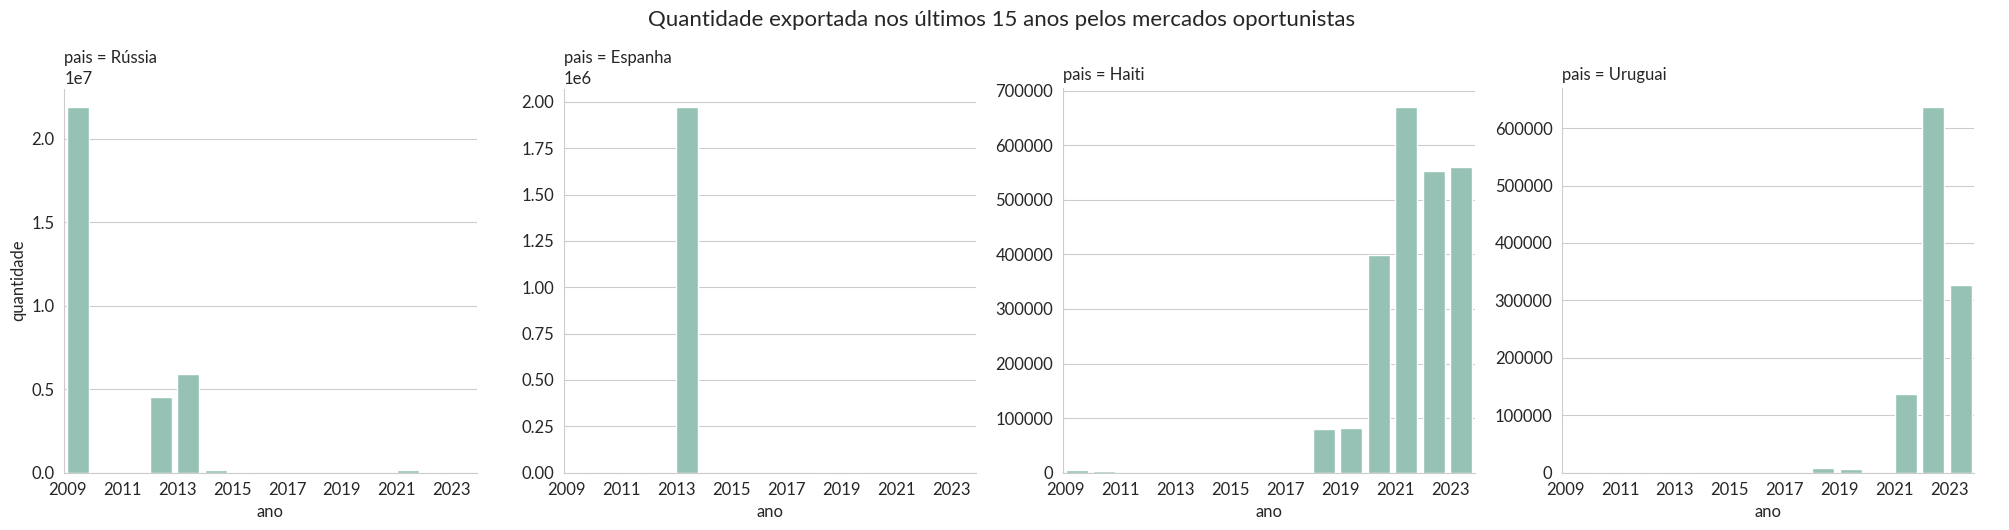

In [ ]:
lista_mercados_oportunistas = mercados_oportunistas['pais'].unique()
df_export_15anos_mercados_oportunistas = df_export_15anos[df_export_15anos['pais'].isin(lista_mercados_oportunistas)].copy()

ax = sns.catplot(data=df_export_15anos_mercados_oportunistas, x='ano', y='quantidade', col='pais', col_order=lista_mercados_oportunistas, kind='bar', sharey=False)
plt.suptitle('Quantidade exportada nos últimos 15 anos pelos mercados oportunistas', fontsize=16, y=1.05)

for ax_single in ax.axes.flat:
    ax_single.xaxis.set_major_locator(ticker.IndexLocator(base=2, offset=0))

plt.show()

Importante destacar que o Haiti passou a exportar vinho da VitiBrasil apenas a partir de 2018 (variação recente positiva). Se ele se mantiver constante, pode virar um mercado fiel dentro de alguns anos.

### Participação percentual de cada segmento no total exportado

In [ ]:
# Adiciona a coluna de segmento
df_export_por_pais['segmento'] = 'Outros'
df_export_por_pais.loc[mercados_fieis.index, 'segmento'] = 'Fiéis'
df_export_por_pais.loc[potencial_expansao.index, 'segmento'] = 'Potencial de Expansão'
df_export_por_pais.loc[mercados_oportunistas.index, 'segmento'] = 'Oportunistas'

In [ ]:
# Tabela com contagem de segmentos por região
tabela_segmentos_por_regiao = pd.crosstab(df_export_por_pais['regiao'], df_export_por_pais['segmento'])
tabela_segmentos_por_regiao

segmento,Fiéis,Oportunistas,Outros,Potencial de Expansão
regiao,,,,
América Central e Caribe,0,1,20,1
América do Norte,1,0,2,0
América do Sul,1,1,9,2
Europa,2,1,24,3
Oceania,0,0,10,0
África,0,0,20,0
Ásia,1,1,21,1


In [ ]:
# Para o gráfico
df_export_15anos_ano_max = df_export_15anos.query('ano == @ano_max').copy()
df_total_ano_max = df_export_15anos_ano_max.sum(numeric_only=True)

df_export_15anos_ano_max['%valor'] = (df_export_15anos_ano_max['valor'] / df_total_ano_max['valor']) * 100
df_export_15anos_ano_max['%quantidade'] = (df_export_15anos_ano_max['quantidade'] / df_total_ano_max['quantidade']) * 100
df_export_15anos_ano_max.sort_values(by='%valor', ascending=False, inplace=True)

df_export_15anos_ano_max = df_export_15anos_ano_max.merge(
    df_export_por_pais[['pais', 'segmento']],
    on='pais',
    how='left'
)

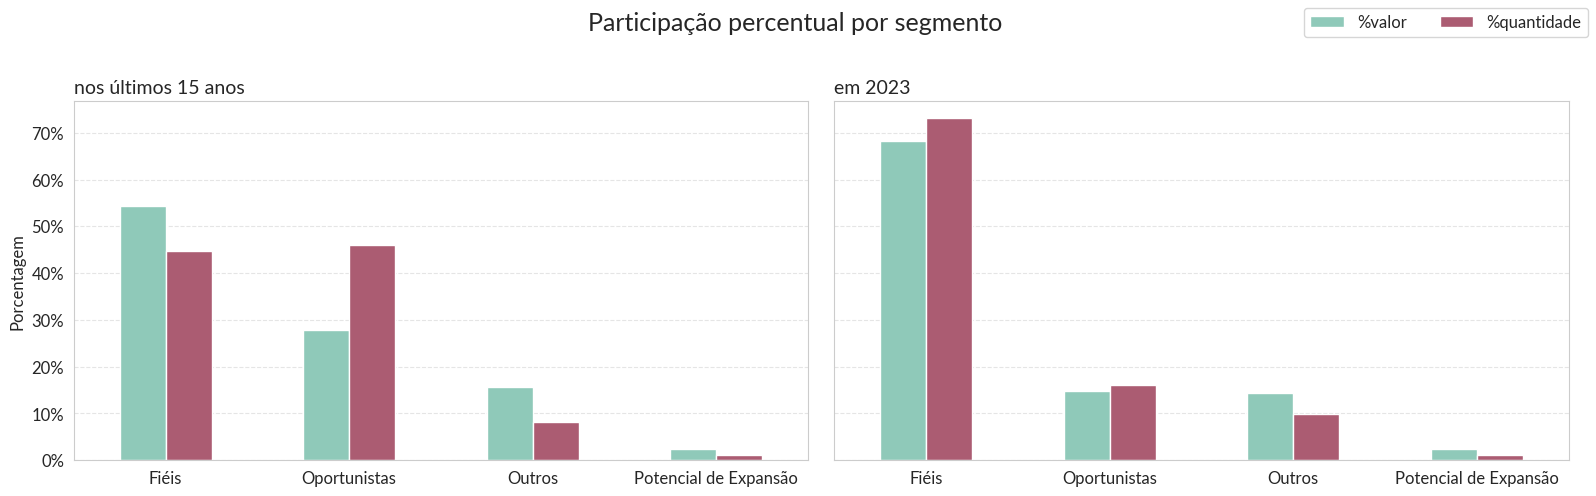

In [ ]:
# Agrupamentos
segmentos_agg_15anos = df_export_por_pais.groupby('segmento')[['%valor', '%quantidade']].sum()
segmentos_agg_ano_max = df_export_15anos_ano_max.groupby('segmento')[['%valor', '%quantidade']].sum()

# Criar figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
plt.suptitle(f'Participação percentual por segmento', fontsize=18)

# Gráfico 1 - últimos 15 anos
segmentos_agg_15anos.plot(
    kind='bar',
    stacked=False,
    color=[paleta_harmonica['azul_claro'], paleta_harmonica['rosa_meio']],
    ax=axes[0]
)
axes[0].set_title('nos últimos 15 anos', fontsize=14)
axes[0].set_ylabel('Porcentagem')
axes[0].set_xlabel('')
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}%'))
axes[0].grid(axis='x', which='both', visible=False)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend().set_visible(False)

# Gráfico 2 - ano mais recente
segmentos_agg_ano_max.plot(
    kind='bar',
    stacked=False,
    color=[paleta_harmonica['azul_claro'], paleta_harmonica['rosa_meio']],
    ax=axes[1]
)

axes[1].set_title(f'em {ano_max}', fontsize=14)
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}%'))
axes[1].grid(axis='x', which='both', visible=False)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend().set_visible(False)

# Adicionar legenda única
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncols=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Nos últimos 15 anos, fiéis compram menos volume, mas pagam mais. Oportunistas têm uma proporção de volume igual à dos fiéis, mas gastam bem menos.
No último ano, fiéis são protagonistas, pois cresceram muito, tanto em valor quanto em volume. Enquanto os oportunistas perderam força.

## Conclusão

Com base no conjunto de indicadores criados durante a análise, os países foram organizados em três perfis estratégicos: fiel, oportunista e potencial de expansão.

Os **mercados fiéis** são aqueles com alto consumo, regularidade nas compras e volumes acima da média. Esse grupo é composto por Paraguai, Estados Unidos, Reino Unido, Países Baixos, Japão e Alemanha. O ideal é fortalecer estratégias de fidelização e desenvolver ações que melhorem o preço médio por litro, uma vez que a maioria apresenta variações negativas recentes na compra de vinhos gaúchos.

Em um segundo grupo, identificamos os **mercados com potencial de expansão**, onde há consumo relevante, frequência de compra consistente, crescimento positivo nas importações e indicadores econômicos favoráveis. Esse perfil inclui Portugal, Hong Kong, Suriname, Suíça, Singapura, Bahamas e Bolívia. São países que podem se tornar estratégicos se forem bem trabalhados comercialmente.

Por fim, os **mercados oportunistas** são aqueles que concentram volumes acima da média, mas sem constância nas compras. A lista é composta por Rússia, Espanha, Haiti e Uruguai. Esses casos exigem monitoramento específico, pois podem indicar tanto oportunidades pontuais como potenciais mercados a serem conquistados.

Como ponto de atenção para planejamentos futuros, ressaltamos que em dezembro de 2024 foi assinado um acordo de livre comércio entre o Mercosul e a União Europeia, o que dá ao Brasil uma ótima oportunidade de expandir suas exportações de vinho. Isso porque a eliminação gradual de tarifas promete facilitar o acesso ao mercado europeu, favorecendo produtores nacionais que investirem em qualidade e diferenciação. Embora o setor enfrente o desafio de competir com os tradicionais vinhos europeus também no mercado interno, o acordo representa uma oportunidade concreta de posicionar o vinho brasileiro internacionalmente, valorizando sua identidade, origem e potencial de crescimento.